# Natural Language Processing with Disaster Tweets

## Problem Description

The problem in this Kaggle competition is a binary classification problem.  We have a dataset containing tweet text and a label indicating whether the tweet is about an actual distaster or not.  This is an interesting problem, because determing the meaning of text often requires understanding meaning of the words and the full context of the text, not just the specific words used.

## Imports and Utility Code

In [1]:
import numpy as np # linear algebra
import pandas as pd
import os
import pathlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import nltk
from nltk.util import ngrams
from nltk.tokenize import TweetTokenizer
import re
from wordcloud import WordCloud
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from keras import regularizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

tqdm.pandas()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def preprocess_text(text):
    text = re.sub(r'[^\w\s@#]', '', text)
    text = text.lower()
    return text

## Exploratory Data Analysis

### Sample Submission and Train Labels Review

Brief review of the sample file, so I know what I need to submit.

In [3]:
sample_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
sample_submission

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0
...,...,...
3258,10861,0
3259,10865,0
3260,10868,0
3261,10874,0


Review of the training file.  In this file, there are 7,613 tweets (textual data from twitter).  Each has a target of 1 or 0, indicating whether it's a tweet about an actual disaster or not respectively.

The tweet data is interesting in a few ways.  Tweets are obviously textual data, but there are also other factors that uniquely add context to tweets, such as hashtags, @ mentions, emojis, etc.

In [4]:
train_data = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
train_data

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


Some examples of disaster tweets:

In [5]:
disaster_tweets = train_data[train_data['target'] == 1]['text']
for i in range(5):
    print(disaster_tweets.iloc[i])

Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Forest fire near La Ronge Sask. Canada
All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
13,000 people receive #wildfires evacuation orders in California 
Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 


Some examples of non-disaster tweets:

In [6]:
non_disaster_tweets = train_data[train_data['target'] == 0]['text']
for i in range(5):
    print(non_disaster_tweets.iloc[i])

What's up man?
I love fruits
Summer is lovely
My car is so fast
What a goooooooaaaaaal!!!!!!


I've generated a couple word cloud visualizations.  While word clouds aren't the most useful visualizations, they do give a quick at a glance sense of textual data.

Disaster tweets:

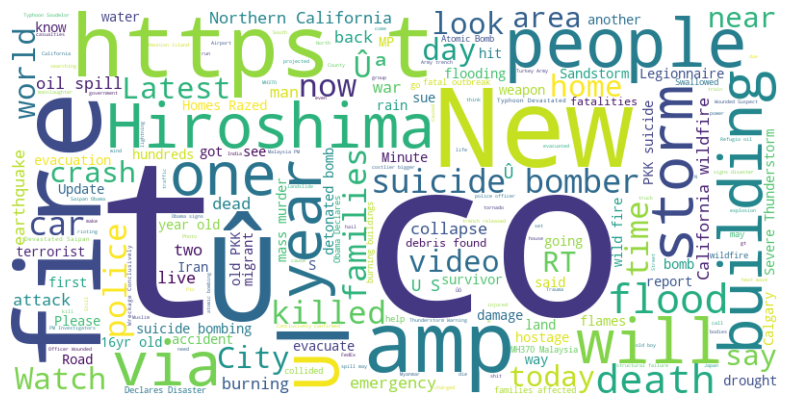

In [7]:
text_data = disaster_tweets.str.cat(sep=' ')

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Non-disaster tweets:

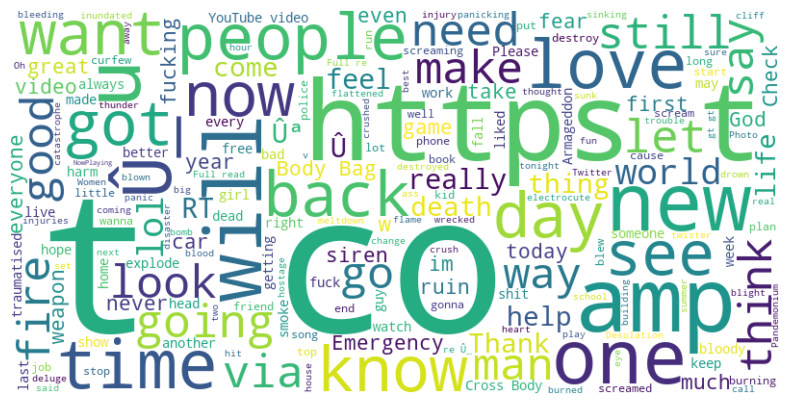

In [8]:
text_data = non_disaster_tweets.str.cat(sep=' ')

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Label Review

The labels are unbalanced, with 4,342 tweets not written about a disaster, and 3,271 tweets written about a disaster.  As a result, I'll be sure to stratify when we prepare the train/test split.  I don't think that this is so unbalanced that we need to resort to under or oversampling, but that might be worth looking at in a future iteration of this project.

target
0    4342
1    3271
Name: count, dtype: int64

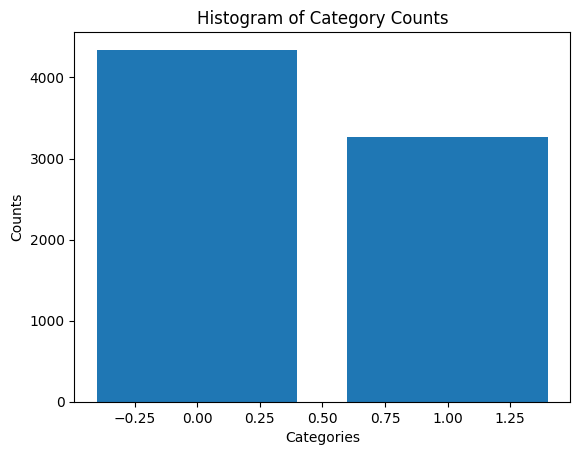

In [9]:
value_counts = train_data['target'].value_counts()
display(value_counts)

plt.bar(value_counts.index, value_counts.values)
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.title('Histogram of Category Counts')
plt.show()

### Keywords Column Review

The dataset includes a keywords column which is filled for a subset of the population.  After reviewing, I chose not to include this in any modelling since these keywords were removed from the context of the remaining text and the full context is what's important for this task.

Keywords for tweets about a disaster:

In [10]:
value_counts = train_data[train_data['target'] == 1]['keyword'].value_counts(dropna = False)
display(value_counts.head(20))

keyword
NaN                    42
wreckage               39
outbreak               39
derailment             39
typhoon                37
debris                 37
oil%20spill            37
rescuers               32
suicide%20bombing      32
suicide%20bomb         32
evacuated              32
razed                  31
nuclear%20disaster     31
earthquake             30
suicide%20bomber       30
airplane%20accident    30
bridge%20collapse      29
collision              29
wildfire               29
mass%20murder          28
Name: count, dtype: int64

Keywords for tweets not about a disaster:

In [11]:
value_counts = train_data[train_data['target'] == 0]['keyword'].value_counts(dropna = False)
display(value_counts.head(20))

keyword
body%20bags    40
harm           37
armageddon     37
deluge         36
ruin           36
wrecked        36
twister        35
explode        35
fear           35
siren          35
screaming      34
aftershock     34
panic          34
blizzard       33
blazing        33
blaze          33
sinking        33
traumatised    33
crush          33
hellfire       32
Name: count, dtype: int64

### Text Pre-processing and Review

For text pre-processing, I:
- remove punctuation with the exception of hashtags and @ symbols.  I leave these in place because they are important to the context of tweets.
- lower case the words.
- split the tweets into lists of words.

In [12]:
train_data['processed_text'] = train_data['text'].apply(preprocess_text)
train_data['word_length'] = train_data['processed_text'].str.split().apply(len)
train_data['words'] = train_data['processed_text'].str.split()

For some of the model hyperparameters required later, I take a look at the number of unique words in the corpus.  I also display some of the top word counts.

In [13]:
word_counts = train_data['words'].explode().value_counts()
max_words = len(word_counts)
print(f"Total number of words: {max_words}")
display(word_counts.head(30))

Total number of words: 23494


words
the     3260
a       2176
in      1976
to      1945
of      1823
and     1418
i       1369
is       943
for      890
on       853
you      793
my       675
with     572
it       567
that     561
at       539
by       519
this     477
from     421
be       401
are      401
was      385
have     384
like     345
as       330
me       322
up       321
just     317
but      317
so       315
Name: count, dtype: int64

I also look at the number of words in each tweet.  This is again for hyperparameter settings later on.

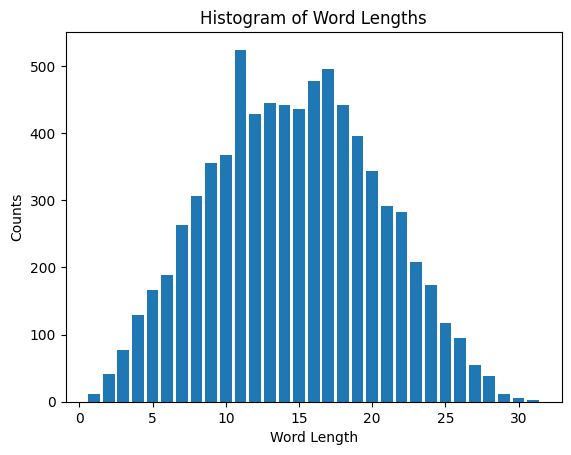

In [14]:
value_counts = train_data['word_length'].value_counts()

plt.bar(value_counts.index, value_counts.values)
plt.xlabel('Word Length')
plt.ylabel('Counts')
plt.title('Histogram of Word Lengths')
plt.show()

## Models

I begin by setting my test/trin splits and doing some pre-processing of the data to get it into a consistent format appropriate for the model inputs.  This included tokenizing, padding so each sequence is a consistent length, and representing the labels as an array.

I then split the data into train/test splits, making sure to stratify since we know there is a slight imbalance in the labels.

I also define my early stopping parameters here, to be used in each model below.

In [15]:
max_sequence_length = 50

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_data['processed_text'])
sequences = tokenizer.texts_to_sequences(train_data['processed_text'])
data = pad_sequences(sequences, maxlen=max_sequence_length)
labels = np.array(train_data['target'])

x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42, shuffle=True, stratify=labels)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
dropout_rate = .25

### One Directional LSTM

My first model is a simple one directional LSTM, a common first architecture for sequential data (like textual data).

I also added dropout and regularization to this first model to attempt to combat overfitting, however these attempts didn't significantly change the performance of the model.

In [16]:
modela = Sequential()
modela.add(Embedding(max_words, 128, input_length=max_sequence_length))
modela.add(LSTM(64, dropout=dropout_rate, recurrent_dropout=dropout_rate))
modela.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01)))

modela.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
modela.summary()

history = modela.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test), callbacks=[early_stopping])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 128)           3007232   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 3,056,705
Trainable params: 3,056,705
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
191/191 [==============================] - 69s 338ms/step - loss: 0.5596 - accuracy: 0.7253 - val_loss: 0.4495 - val_accuracy: 0.8168
Epoch 2/10
191/191 [==============================] - 50s 263ms/step - loss: 0.3160 - accuracy: 0.8788 - val_loss: 0.4706 - val_accuracy: 0.8037
Epoch 3/10
191/191 [

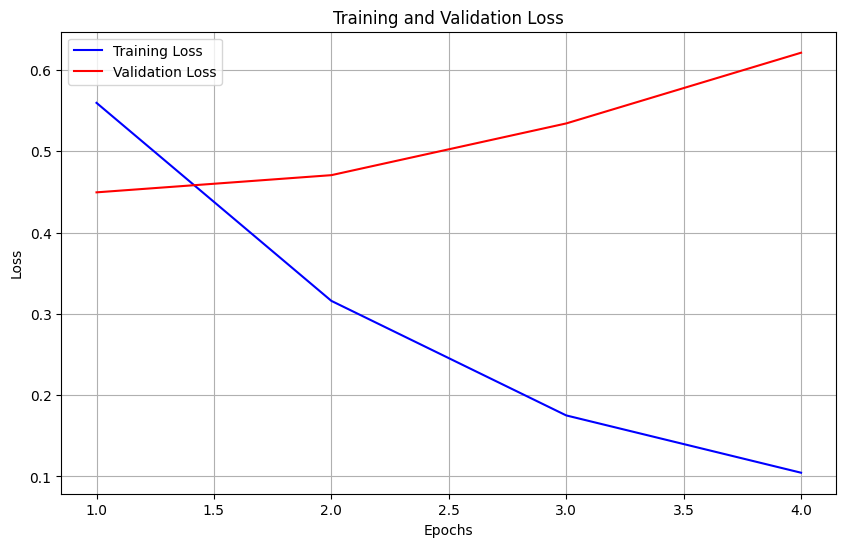

In [17]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### Bidirectional LSTM

My second model is a bidirectional LSTM.  Bidirectional LSTMs process this sentence both forwards and backwards.  This is useful for sentence data, since we often write sentences where words later in a sentence add context to words before it.  For instance, "Because she

In [18]:
modelb = Sequential()
modelb.add(Embedding(max_words, 128, input_length=max_sequence_length))
modelb.add(Bidirectional(LSTM(64)))
modelb.add(Dense(1, activation='sigmoid'))

modelb.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
modelb.summary()

history = modelb.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test), callbacks=[early_stopping])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 128)           3007232   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 3,106,177
Trainable params: 3,106,177
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
191/191 [==============================] - 20s 82ms/step - loss: 0.5269 - accuracy: 0.7366 - val_loss: 0.4352 - val_accuracy: 0.8155
Epoch 2/10
191/191 [==============================] - 5s 24ms/step - loss: 0.2645 - accuracy: 0.89

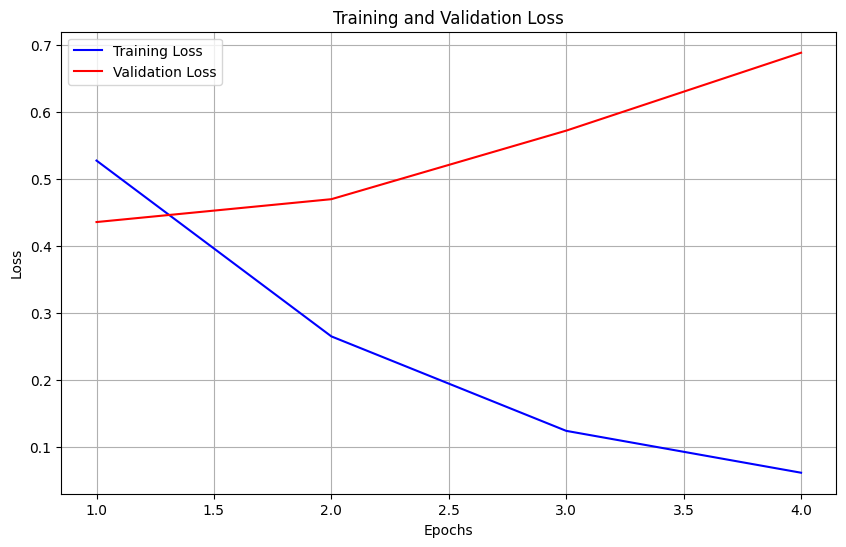

In [19]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### Larger Embeddings with Bidirectional LSTM

My third model is a bidirectional LSTM again, however I have increased the embedding size and the LSTM units.

In [20]:
modelc = Sequential()
modelc.add(Embedding(max_words, 300, input_length=max_sequence_length))
modelc.add(Bidirectional(LSTM(128)))
modelc.add(Dense(1, activation='sigmoid'))

modelc.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
modelc.summary()

history = modelc.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test), callbacks=[early_stopping])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 300)           7048200   
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              439296    
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 7,487,753
Trainable params: 7,487,753
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
191/191 [==============================] - 25s 107ms/step - loss: 0.5203 - accuracy: 0.7397 - val_loss: 0.4235 - val_accuracy: 0.8168
Epoch 2/10
191/191 [==============================] - 6s 28ms/step - loss: 0.2473 - accuracy: 0.9

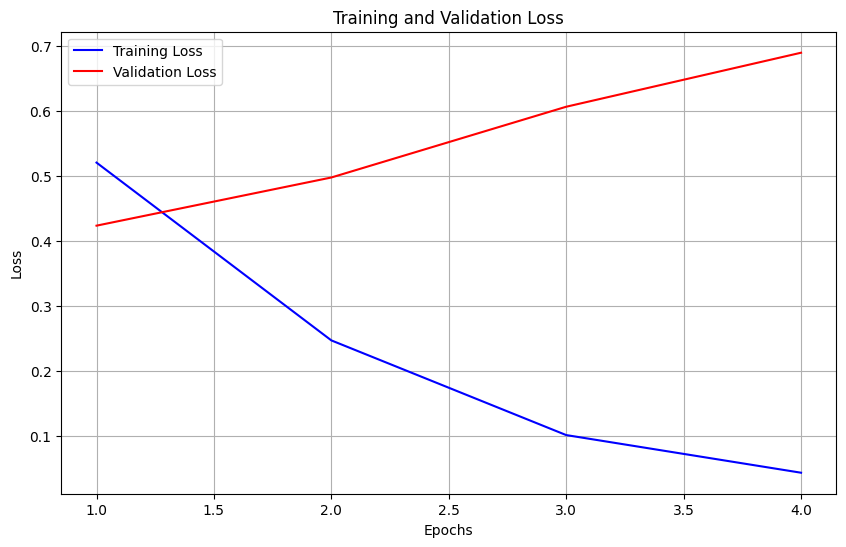

In [21]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### Three Bidirectional LSTM Layers

Next, I attempted a model with three Bidirectional LSTM layers to see if a deeper, more complex model would fit better.

In [22]:
modeld = Sequential()
modeld.add(Embedding(max_words, 128, input_length=max_sequence_length))
modeld.add(Bidirectional(LSTM(64, return_sequences=True)))
modeld.add(Bidirectional(LSTM(64, return_sequences=True)))
modeld.add(Bidirectional(LSTM(64)))
modeld.add(Dense(1, activation='sigmoid'))

modeld.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
modeld.summary()

history = modeld.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test), callbacks=[early_stopping])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 50, 128)           3007232   
                                                                 
 bidirectional_2 (Bidirectio  (None, 50, 128)          98816     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 50, 128)          98816     
 nal)                                                            
                                                                 
 bidirectional_4 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                      

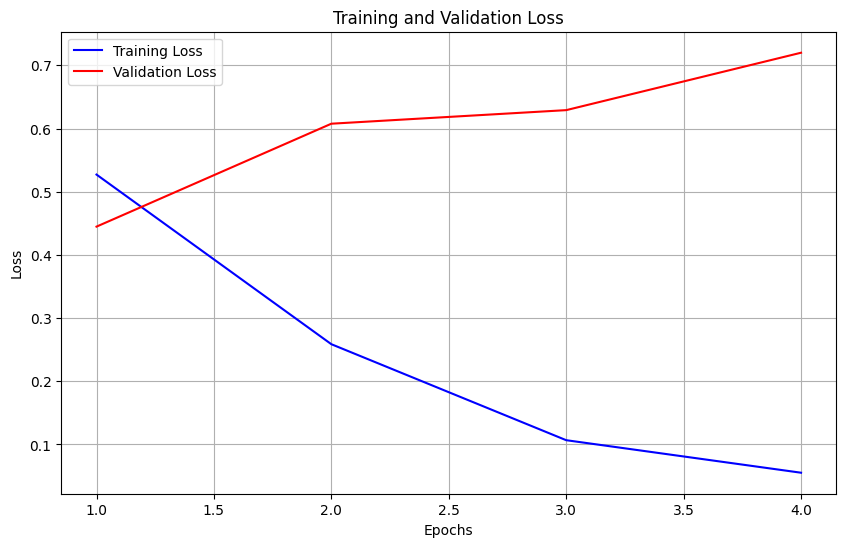

In [23]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### BERT

Finally, I attempted to fit a model using the pre-trained BERT model.

In [24]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
def tokenize_text(text):
    tokens = tokenizer.encode(text, add_special_tokens=True, max_length=max_sequence_length, padding='max_length', truncation=True)
    return tokens

train_data['tokens'] = train_data['processed_text'].progress_apply(tokenize_text)

x_train, x_test, y_train, y_test = train_test_split(train_data['tokens'].tolist(), train_data['target'].tolist(), test_size=0.2, random_state=42, shuffle=True)

100%|██████████| 7613/7613 [00:06<00:00, 1226.56it/s]


In [25]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(64)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(64)

bert_model = TFBertModel.from_pretrained("bert-base-uncased")

input_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int32)
bert_output = bert_model(input_ids)[0]
cls_token = tf.keras.layers.Lambda(lambda x: x[:, 0, :])(bert_output)
output = tf.keras.layers.Dense(1, activation='sigmoid')(cls_token)
modele = tf.keras.models.Model(inputs=input_ids, outputs=output)

optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
modele.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
modele.summary()

modele.fit(train_dataset, epochs=10, validation_data=test_dataset, callbacks=[early_stopping])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 tf_bert_model (TFBertModel)  TFBaseModelOutputWithPoo  109482240
                             lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             50, 768),                           
                              pooler_output=(None, 76            
                             8),                                 
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                                             

## Predictions on Test Data

Below, I performed my predictions using the BERT model on the test data for submission.

In [42]:
test_data = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

test_data['processed_text'] = test_data['text'].apply(preprocess_text)
test_data['tokens'] = test_data['processed_text'].progress_apply(tokenize_text)
input_data = tf.convert_to_tensor(test_data['tokens'].tolist())

100%|██████████| 3263/3263 [00:02<00:00, 1194.21it/s]


In [49]:
predictions = modele.predict(input_data)
test_data['target'] = [1 if pred >= 0.5 else 0 for pred in predictions]

102/102 [==============================] - 12s 113ms/step


In [50]:
test_data[['id', 'target']].to_csv('/kaggle/working/submission.csv', index=False)

## Results and Analysis

My model attempt results are as follows:

| Model | Validation Accuracy |
|-------|----------|
|One Directional LSTM|0.8168|
|Bidirectional LSTM|0.8155|
|Larger Embeddings with Bidirectional LSTM|0.8168|
|Three Bidirectional LSTM Layers|0.8096|
|BERT|0.8477|

It's not surprising the bidirectional LSTM layers perform better than single directional LSTM layers, since context in written language can flow forward or backward throughout the sentence.

It was interesting that more LSTM layers appeared to perform worse.  This suggests there may be diminishig returns as model complexity increases.

Unsurprisingly, BERT performed the best, however not significantly better than the standard models.

## Conclusion

BERT was my best performing model, giving me a score of 0.83297 when used to predict against the test data.

Learnings and Takeaways / Discussion of why something didn’t work:

I noticed that each of my models, regardless of what architectures or hyperparameters I chose, appeared to have overfit after the first epoch.  I would like to further investigate why that was.  I suspect it may simply be due to the low volume of data used in this project.

Suggestions for ways to improve:

While I did preprocess the text, there are likely ways the text could have been further prepared.  I would have liked to have used lemmatization in my preprocessing, but I could not find a way to get Kaggle to process it.  In addition, when removing punctuation, I might be removing some important pieces of information such as emojis.

A greater amount of data may also have helped get better accuracy scores.